# layerwise relevance propagation

主要参考以下资料简单了解LRP的基本概念。

- [InDepth: Layer-Wise Relevance Propagation](https://towardsdatascience.com/indepth-layer-wise-relevance-propagation-340f95deb1ea)
- [Layer-Wise Relevance Propagation: An Overview](https://link.springer.com/chapter/10.1007%2F978-3-030-28954-6_10)
- [www.heatmapping.org](http://www.heatmapping.org/)
- [Why&How: Interpretable ML](https://towardsdatascience.com/why-how-interpretable-ml-7288c5aa55e4)
- [Opening the black box of LSTM models using XAI](https://agu.confex.com/agu/fm20/videogateway.cgi/id/29034?recordingid=29034)

分层相关性传播 (LRP) 是可解释机器学习 (XML) 中最突出的方法之一。这里简单记录 LRP 的细节和实现它的一些技巧。

LRP的目的是提供一个对任何神经网络输出在其输入域内的解释，即对每个预测，每个输出的贡献有多少；每个输入对输出总的贡献有多少等。比如网络根据乳房 X 光照片（乳房组织的图像）预测癌症诊断，那么 LRP 给出的解释将是展示原始图像中哪些像素有助于诊断以及在多大程度上有助于诊断的图。此方法不与网络的训练交互，因此可以轻松地将其应用于已训练的分类器。

XML 方法在安全很关键领域特别有用，在这些领域中，从业者必须确切地知道网络正在关注什么。其他用例包括网络（错误）行为的诊断、科学发现和改进网络架构。

## 方法介绍

直观地说，LRP 所做的是，它使用网络权重和由前向传递创建的神经激活将输出传播回网络，直到输入层。在那里，我们可以可视化哪些像素真正对输出做出了贡献。我们将每个像素或中间神经元的贡献大小称为“相关性”值R。

LRP 是一种守恒的技术，这意味着任何输出y的大小通过反向传播过程都是守恒的，并且等于输入层的相关图R的总和。此属性适用于任何连续的层j和k，以及输入和输出层的传递性。

一步一步来。假设网络是一个分类器，它的输出是一个大小为M的向量，其中每一项对应于M 个类之一。在输出层，我们选择一个我们想要解释的神经元或类。对于这个神经元，相关性等于它的激活，输出层中所有其他神经元的相关性为零。举例来说，如果我们要使用LRP找出网络中的神经元和输入对于预测类ç的相关性，我们先从输出神经元类ç开始，看看网络如何到达这个神经元的值。

然后，我们按照这个基本的 LPR 规则在网络中倒行：

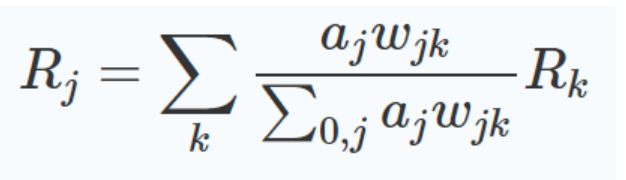LRP-0

这里，j和k是任意连续层的两个神经元。我们已经知道输出层中的相关性R，所以我们将从那里开始，并迭代地使用这个公式来计算前一层的每个神经元的R。a表示各个神经元的激活，w是两个神经元之间的权重。

这是最简单的 LRP 规则。根据应用程序，可能希望使用不同的规则，这将在后面讨论。它们都遵循相同的基本原则。

现在，这个公式是什么意思？分子是神经元j对神经元k 的影响量。为了加强上面的守恒性质，必须除以下层所有神经元的贡献总和。我们通常在分母上添加一个非常小的常数 ϵ 以使分数更稳定。k 上的外部总和意味着神经元j的相关性由其对下一层所有神经元k的影响之和乘以这些神经元的相关性决定。

我们可以简单地从最后一层直到第一层。根据我们选择从哪个输出神经元开始，我们可以获得任何类别的解释。因此，我们甚至可以检查网络认为与预测任何A类相关的内容，即使它实际上预测了B类！

没有特别限制可以这样分析的网络结构，LRP 适用于 CNN，也可以用于 LSTM。但是，要求网络仅包含 ReLU 激活函数。

为了更好地了解应用此公式时正在进行的过程，将其解释为 4 步过程。

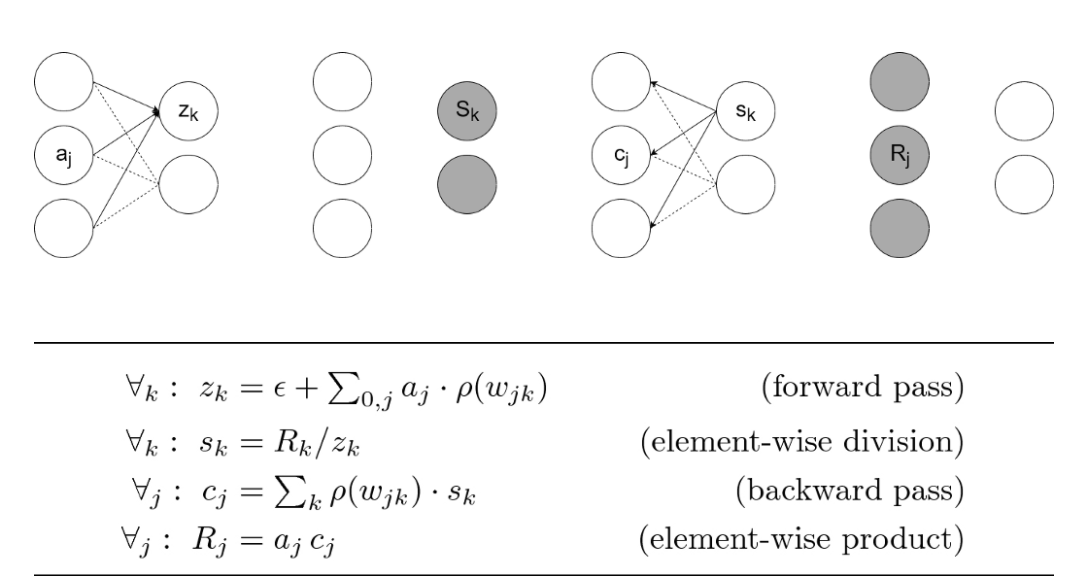

第一步确定上层每个神经元影响的总和，类似于一个修改版的前向传播。请注意，对于 ReLU 层，它与正常前向传递相同，除了我们添加一个小的常数 ϵ 并在我们的权重周围包裹一个函数 ρ。这个 ρ 只是为了使公式更通用，并包含我们稍后将看到的所有可能的 LRP 规则。在我们之前的情况下，ρ 将是恒等函数，这意味着我们可以忽略它。

请注意，总和经过了下层中的每个神经元 j，也经过了偏置神经元。在接下来的所有步骤中，偏置将被忽略，因为我们希望相关性仅流向输入神经元，而不是最终进入静态偏置神经元。

在第二步中，我们简单地将每个神经元在更高层中的相关性除以之前计算的z值。这确保了守恒性质成立。

在第三步中，我们为前一层中的每个神经元计算一个数量c，因此可以将其视为反向传播。这个c可以粗略地看作是有多少相关性从后续层向下传递到神经元j。

最后，在第四步中，将来自上面的相关性与神经元的激活相乘以计算其自身的相关性。直观地说，一个神经元是相关的，如果 1) 它具有高激活，并且 2) 它对更高层的相关神经元贡献很大。

现在应该已经能够自己实现 LRP 了！如果只想开箱即用地使用它，请注意已经有[出色的实现](https://github.com/albermax/innvestigate)

## 实现技巧

首次介绍时，LRP 的作者提供了一个伪代码片段，该片段将通过网络逐层计算相关性。（查看这个[简短的教程](https://git.tu-berlin.de/gmontavon/lrp-tutorial)来实现这个基本版本）随着他们自己应用 LRP 的经验越来越丰富，他们发布了一种更有效的方法来实现它。

关键部分是利用高效的 autograd 框架，例如 pytorch 或 tensorflow 为我们进行反向传递。

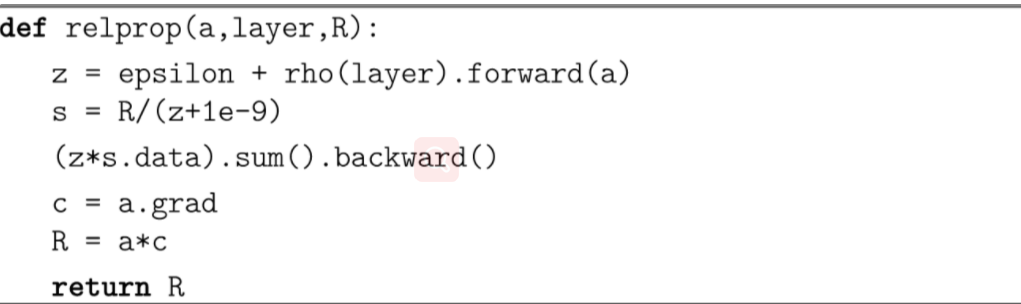

与我们上面看到的公式的最大区别在于，我们将c值计算为梯度计算。

!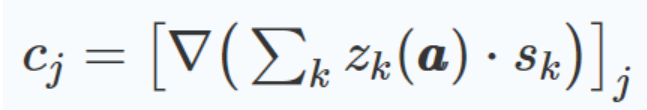

这使我们能够利用高效的自动反向传播运算。为了解决这个问题并给出正确的结果，我们必须将 s 视为一个常数。这由上面代码中的 .data 指示。

要注意 LRP 有不同的传播规则，可能希望将其中的几个组合起来以获得最佳结果。幸运的是，[这里](https://link.springer.com/chapter/10.1007%2F978-3-030-28954-6_10)有一个最重要规则的整洁列表，并附有关于何时使用它们的建议。

输入层：对于图像，LRP 的作者在Deep Taylor Decomposition 论文中引入了选择规则，并采用以下形式：

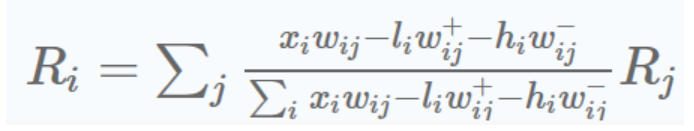LRP-z

这里l和h分别是允许的最低和最高像素值。

低层：这里我们希望解释更流畅，噪音更小，因为这些层已经非常接近我们人类将看到并且必须理解的相关图。为此，我们可以使用 LRP-γ 规则，即不成比例地支持正面证据而不是负面证据：

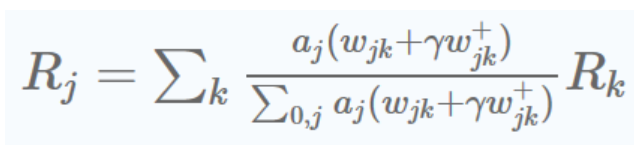LRP-γ

高层：上面的 LRP-γ 或以下 LRP-ϵ 规则在这里都可以很好地工作。他们从相关图中去除了一些噪音。特别是，ϵ 会吸收一些小的或矛盾的证据。

 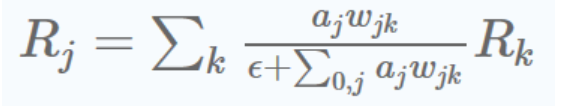LRP-ϵ

输出层：这里我们理想地使用未修改的 LRP-0 规则。

还有比这些更多的规则，但是此处看到的规则足以满足大多数应用程序的要求。如果选择正确的规则过于复杂，请不要担心！仅仅 LRP-0 和 LRP-ϵ 应该就足够了，一旦得到了符合这些规则的解释，总是可以决定是否花时间试验其他规则并使解释更漂亮。为了对不同的规则有一点直观的了解，建议玩一下[交互式演示](https://lrpserver.hhi.fraunhofer.de/image-classification)。

# Implementing Layer-Wise Relevance Propagation
如概述文章中所述:[Layer-Wise Relevance Propagation:An Overview](http://iphome.hhi.de/samek/pdf/MonXAI19.pdf)解释了如何轻松有效地实现分层关联传播(LRP)  

我们考虑了两个模型:  
(1)一个简单的纯深度整流网络训练的MNIST手写数字数据，  
(2)VGG-16网络训练的ImageNet，适用于一般的图像分类。

# 1 Numpy Implementation for a Fully-Connected Network 
我们首先加载12个MNIST样例测试数字。

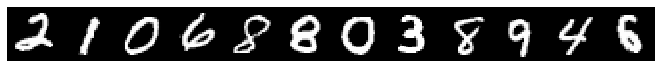

In [1]:
import utils
X,T = utils.loaddata()
%matplotlib inline
utils.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

每个数字存储为784维的像素值向量，其中“-1.0”对应黑色，“+1.0”对应白色
## 1.1 预测MNIST数字的类别
这些数字被输入到一个层号为784-300-100-10的完全连接的神经网络，每个隐藏层都激活ReLU。该体系结构如下图所示。
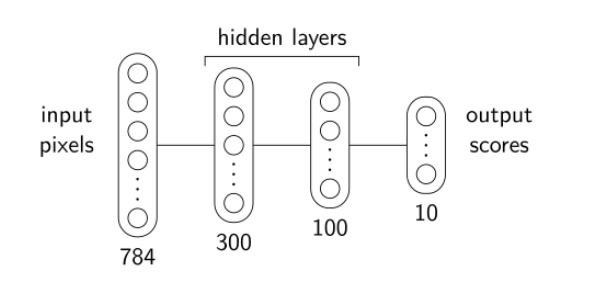   

我们所考虑的网络实现了1.6%的误差，这是没有特定结构或正则化的神经网络的典型性能。函数```utils.loadparams()```为我们检索它的参数。


In [2]:
W,B = utils.loadparams()
L = len(W)

从这些参数，前向传递可以计算为矩阵乘法和非线性序列

In [3]:
import numpy
A = [X]+[None]*L
for l in range(L):
    A[l+1] = numpy.maximum(0,A[l].dot(W[l])+B[l])

注意，与原始神经网络相比，这段代码增加了一个额外的顶层ReLU激活。然而，当看到积极的输出分数时，这并不影响计算。最上层的激活值是衡量网络为每个类找到的证据的分数。下面，我们在输出中显示了前三位数字和每个类产生的分数:

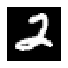

[0] 0.0  [1] 3.6  [2] 49.1  [3] 8.9  [4] 0.0  [5] 0.0  [6] 0.0  [7] 1.4  [8] 1.6  [9] 0.0


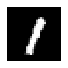

[0] 0.0  [1] 27.0  [2] 0.0  [3] 0.0  [4] 5.3  [5] 0.0  [6] 0.0  [7] 13.0  [8] 8.1  [9] 2.3


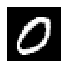

[0] 49.1  [1] 0.0  [2] 10.6  [3] 0.0  [4] 0.0  [5] 0.2  [6] 0.0  [7] 3.0  [8] 0.0  [9] 9.2


In [4]:
for i in range(3):
    utils.digit(X[i].reshape(28,28),0.75,0.75)
    p = A[L][i]
    print("  ".join(['[%1d] %.1f'%(d,p[d]) for d in range(10)]))


正如预期的那样，最高的分数系统地对应着正确的数字。

## 1.2 用LRP解释预测
我们现在实现了从网络的顶部到底部的分层相关传播(LRP)过程。作为第一步，我们创建一个列表来存储每一层的相关性得分。顶层的相关性得分被设置为顶层的激活，我们将其乘以一个标签指示器，以便仅保留实际类的证据。

In [5]:
R = [None]*L + [A[L]*(T[:,None]==numpy.arange(10))]

[Layer-Wise Relevance Propagation:An Overview](http://iphome.hhi.de/samek/pdf/MonXAI19.pdf)(第10.2.1节)中关于低层传播相关性的LRP-0、LRP- ε和LRP-γ规则是更一般传播规则的特殊情况
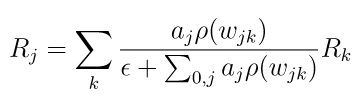  

(参见第10.2.2节)，其中ρ是转换重量的函数，柱一是小的正增量。我们在下面定义两个辅助函数，它们执行权值转换和增量。实际上，我们希望在不同的层上应用不同的规则(参见第10.3节)。因此，我们也将层索引“l”作为这些函数的参数。

In [6]:
def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * numpy.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

特别是，这些函数及其作为参数的层让我们将一般规则简化为顶层的LRP-0，其下一层的LRP-E e= 0.1std，前一层的LRP-y y=0.1。现在我们来看看这个通用规则的实际实现。它可以分解为四个计算序列:

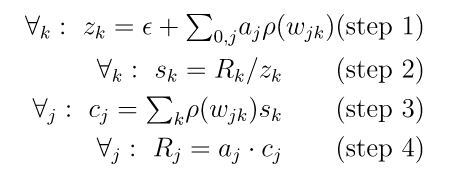   
然后，逐层关联传播过程以相反的顺序遍历各层，从顶层开始到第一层，并在每一层应用此计算序列。

In [7]:
for l in range(1,L)[::-1]:

    w = rho(W[l],l)
    b = rho(B[l],l)
    
    z = incr(A[l].dot(w)+b,l)    # step 1
    s = R[l+1] / z               # step 2
    c = s.dot(w.T)               # step 3
    R[l] = A[l]*c                # step 4

注意上面的循环在到达像素之前停止了一层。为了传播相关性得分直到像素，我们需要应用另一种传播规则，正确处理作为输入接收的像素值。特别是，我们为这一层应用zb规则

在这个规则中，li和hi是像素值的下界和上界，即。“-1”和“+1”，以及(·)+和(·)-是max(0，·)和min(0，·)的快捷表示法。zb规则可以再次通过一个四步过程实现，类似于上面的层中使用的过程。在这里，我们需要创建权重的两个副本，并创建分别设置为li和hi的像素值数组:

In [8]:
w  = W[0]
wp = numpy.maximum(0,w)
wm = numpy.minimum(0,w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9        # step 1
s = R[1]/z                                        # step 2
c,cp,cm  = s.dot(w.T),s.dot(wp.T),s.dot(wm.T)     # step 3
R[0] = A[0]*c-lb*cp-hb*cm                         # step 4

我们现在已经到了底层。得到的像素级相关性得分可以呈现为热图。

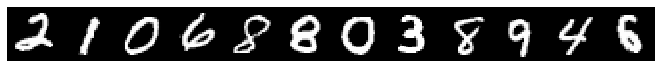

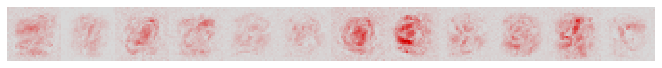

In [9]:
utils.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
utils.heatmap(R[0].reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

相关像素用红色突出显示。对预测有负面影响的像素(如果有的话)用蓝色表示。对于大多数数字，我们发现数字本身以及背景的某些部分都被高亮显示。例如，我们观察到数字“3”旁边有两个红色水平条，突出显示如果这些像素不同，数字3很可能会变成“8”。数字“4”上方支持类“4”而不是类“9”的竖条也是如此。

# 2 PyTorch实现的VGG -16网络

在上面的例子中，LRP规则可以很容易地用矩阵向量运算表示。在实践中，最先进的神经网络如vg -16利用了更复杂的层，如卷积和池化。在这种情况下，通过将上述四步步骤的操作转换为在这些层上的正向和梯度评估，可以更方便地实现LRP规则。这些操作在神经网络框架(如PyTorch和TensorFlow)中很容易获得，因此可以重用来实现LRP。这里，我们使用VGG-16预训练网络进行图像分类。对于这个网络，我们考虑解释如下图所示的类“城堡”的证据

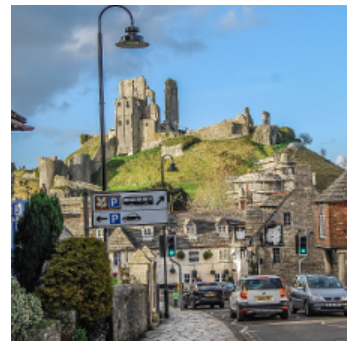


图像首先载入笔记本。

In [4]:
from matplotlib import pyplot as plt
import numpy
img = numpy.array(plt.imread('data/castle.jpg'))[...,::-1]/255.0

然后将其转换为适当维数的 torch 张量，并归一化后作为vg -16网络的输入。

In [5]:
import torch

mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std


然后加载vg -16网络，将其顶层稠密层转换为等价的1x1卷积。

In [6]:
import torchvision
import utils
model = torchvision.models.vgg16(pretrained=True); model.eval()
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\11445/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## 2.1  Predicting the class of an image

然后，输入可以在网络中传播，并收集每一层的激活:

In [7]:
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])

最顶层的激活是神经网络预测的每个类的分数。以下是得分最高的10个类:

In [8]:
scores = numpy.array(A[-1].data.view(-1))
ind = numpy.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

church, church build (497):  8.657
              castle (483):  8.214
traffic light, traff (920):  8.080
cab, hack, taxi, tax (468):  7.630
        analog clock (409):  7.522
 bell cote, bell cot (442):  7.259
cinema, movie theate (498):  7.145
               crane (517):  6.927
         street sign (919):  6.922
             monitor (664):  6.859


我们观察到神经元城堡(指数483)得分最高。这是意料之中的，因为图像中有一座城堡。需要注意的是，其他与建筑相关的类以及与图像中出现的其他对象(如路标和交通灯)相对应的类也会获得高分。

## 2.2用LRP解释预测
下面的代码以相反的顺序从顶层迭代到第一层，并在每一层应用传播规则。顶层激活首先乘以掩码，只保留类“castle”的预测证据。

In [9]:
T = torch.FloatTensor((1.0*(numpy.arange(1000)==483).reshape([1,1000,1,1])))

R = [None]*L + [(A[-1]*T).data]

然后，通过在每一层应用传播规则，该证据可以在网络中向后传播。    
**卷积层**:观察到卷积是线性层的特殊类型，我们可以使用与MNIST例子中相同的传播规则，以及一个类似的四步程序来应用这些规则。步骤2和步骤4是简单的元素计算。步骤1可以实现为层内的正向计算，我们已经对层参数进行了初步的变换，然后应用增量函数。如LRP概述文章所示，Step 3可以作为输入激活空间中的梯度计算:   
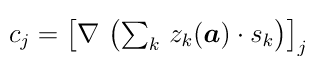  
把sk当作常数。

**池化层**:本文10.3.2节建议将最大池化层作为向后传递的平均池化层。注意到平均池也是一种特殊的线性层，就可以使用与卷积层相同的传播规则。
在下面的代码中，我们将传播过程从顶层迭代到底层。当我们遇到最大池层时，我们将其转换为平均池层。函数```rho```和```incr```在每一层设置不同，遵循10.3节的策略。


In [10]:
for l in range(1,L)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
        if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))  # step 1
        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = A[l].grad                  # step 3
        R[l] = (A[l]*c).data                                   # step 4
        
    else:
        
        R[l] = R[l+1]


由于每一层都由一组二维特征图组成，因此每一层的相关性得分可以可视化为一个二维图。在这里，相关性得分在给定层的所有特征地图上集合。二维地图显示了vg -16层的选择。

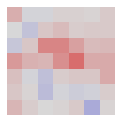

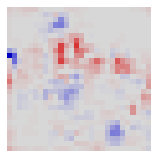

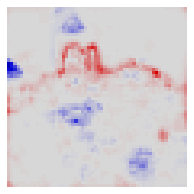

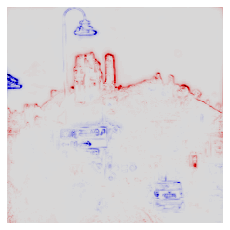

In [11]:
for i,l in enumerate([31,21,11,1]):
    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

我们注意到解释在空间上变得越来越清晰。注意，与MNIST示例一样，我们在像素之前一层停止了传播过程，因为我们使用的规则不适用于像素层。就像MNIST的情况一样，我们不需要为最后一层应用像素特定的zb规则。该规则可以通过前向传递和梯度计算再次实现。

In [12]:
A[0] = (A[0].data).requires_grad_(True)

lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
s = (R[1]/z).data                                                      # step 2
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4


在像素层中获得的相关性得分现在可以在RGB通道上求和，以表示实际的像素级贡献。

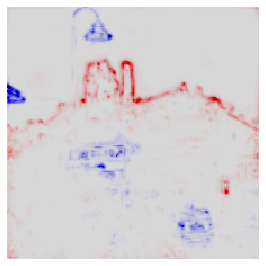

In [13]:
utils.heatmap(numpy.array(R[0][0]).sum(axis=0),3.5,3.5)

我们观察到热图突出了城堡的轮廓作为对应类的证据。一些元素，如交通标志或左边的屋顶被认为对神经元“城堡”有负面影响，因此用蓝色突出显示。